In [1]:
!pip install -q kaggle
!pip install -Uqq fastai

from google.colab import files

files.upload()
print()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c digit-recognizer

!unzip *.zip -d data

Saving kaggle.json to kaggle.json

  0% 0.00/15.3M [00:00<?, ?B/s]
100% 15.3M/15.3M [00:00<00:00, 201MB/s]
Archive:  digit-recognizer.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


In [2]:
import pandas as pd

PATH = '/content' #home directory, in google colab PATH=/content

ds = pd.read_csv(f'{PATH}/data/train.csv')
ds.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#Turning CSV labeled file into images

In [3]:
import numpy as np
from PIL import Image

!mkdir mnist_data

for digit in range(10):
    dir_name = f"mnist_data/{digit}"
    !mkdir $dir_name


def make_picture_from_row(row, n):
  label = row.label # = row['label']

  pixels = np.array(row[1:]).reshape(28,28)

  img = Image.fromarray(pixels.astype('uint8'), 'L') #turning 28x28 matrix into image

  img.save(f'{PATH}/mnist_data/{label}/{n}.jpg')


for r in range(len(ds)):
  make_picture_from_row(ds.iloc[r], r)

In [4]:
import os
path = f'{PATH}/mnist_data'
def get_list(path):
    l = []
    for plik in os.listdir(path):
        if os.path.isfile(os.path.join(path, plik)):
            l.append(plik)
    return l

get_image_files  = get_list(path)


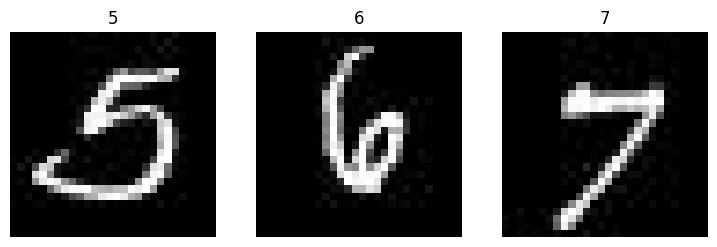

In [5]:
from fastai.vision.all import *

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label).dataloaders(path, bs=32)

dls.show_batch(max_n=3)

In [6]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.837794,0.608943,0.190238,00:55


epoch,train_loss,valid_loss,error_rate,time
0,0.189483,0.085922,0.025238,01:28
1,0.104560,0.051386,0.014405,01:26
2,0.046510,0.045932,0.012857,01:28


# Submitting

In [7]:
test = pd.read_csv(f"{PATH}/data/test.csv")
!mkdir test_data

def make_picture_from_row(row, n):

  pixels = np.array(row).reshape(28,28)

  img = Image.fromarray(pixels.astype('uint8'), 'L')

  img.save(f'{PATH}/test_data/{n}.jpg')


for r in range(len(test)):
  make_picture_from_row(test.iloc[r], r)

In [15]:
#manual check

sub = []
num,_,probs = learn.predict(PILImage.create(f'{PATH}/test_data/2.jpg'))
print(f"This is a: {num}.")

#2, 0, 9, 9, 3, 7, 0

This is a: 9.


In [9]:
from fastai.vision.all import *
import os

path = f'{PATH}/test_data/'
test_files = get_image_files(path)

def extract_number(path):
    return int(re.search(r'(\d+)\.jpg$', str(path)).group(1))

sorted_paths = sorted(test_files, key=extract_number)

dl = learn.dls.test_dl(sorted_paths)
predictions = learn.get_preds(dl=dl)

predicted_classes = torch.argmax(predictions[0], dim=1)

sub = predicted_classes.numpy().tolist()

In [10]:
import csv
columns = ["ImageId", "Label"]

csv_file_path = f"{PATH}/submission.csv"

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(columns)

    for row in range(len(sub)):
        writer.writerow([row+1, sub[row]])